In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../..')

#sys.path.append('../../../TCST/HAMPpred_final/')


from hamp_pred.src.predictor import Predictor
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import RadianEncoder, MultiEncoder, OneHotEncoderSeq, RadiousPhobosEncoder
from hamp_pred.src.predictor_config import  PredictionConfig
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper

2023-04-11 09:49:51.851107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_DIR = '../../data/input'

In [3]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)

model_conf = model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 80
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
mod = Predictor('hamp_rot', config=conf)

In [4]:
#data = f'{DATA_DIR}/af2_clean_model_1.p' # beta 13 val

data = f'{DATA_DIR}/af_clean_model_train_val.p' # beta 13 val




data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)
data['class'].value_counts()

train    4227
val       373
Name: class, dtype: int64

In [5]:
#trained = mod.train(data)

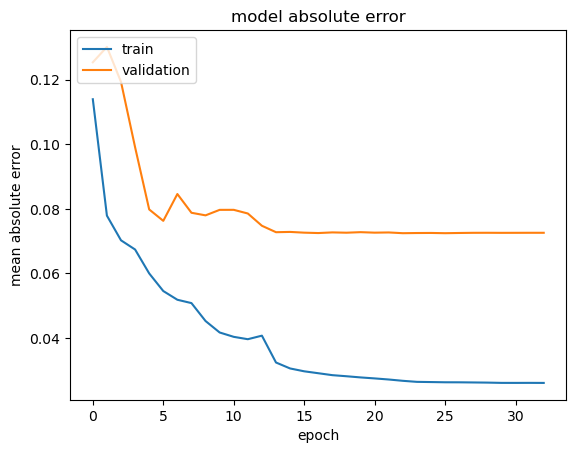

In [33]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

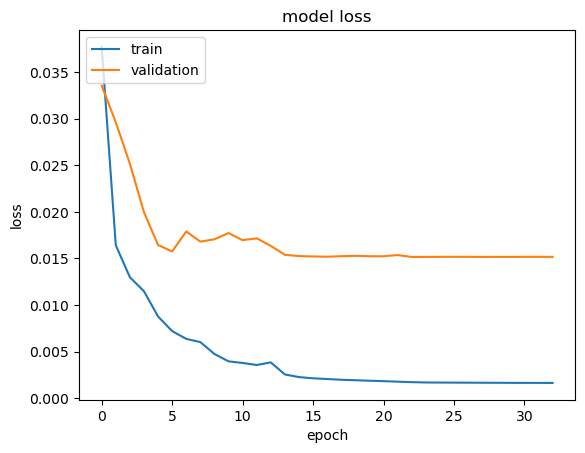

In [34]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Performance on the PDB set

In [6]:
data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
data = data[~data.mutant]
data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(data)

11

In [7]:
res = mod.predict(data.train_seq)

2023-04-11 09:49:57.658400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 09:49:57.660368: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 2s 2s/step


In [8]:
tr=[]
for n,r in data.iterrows():
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['predicted_rotation'])/2)

Text(0.5, 1.0, 'HAMPpred model #1')

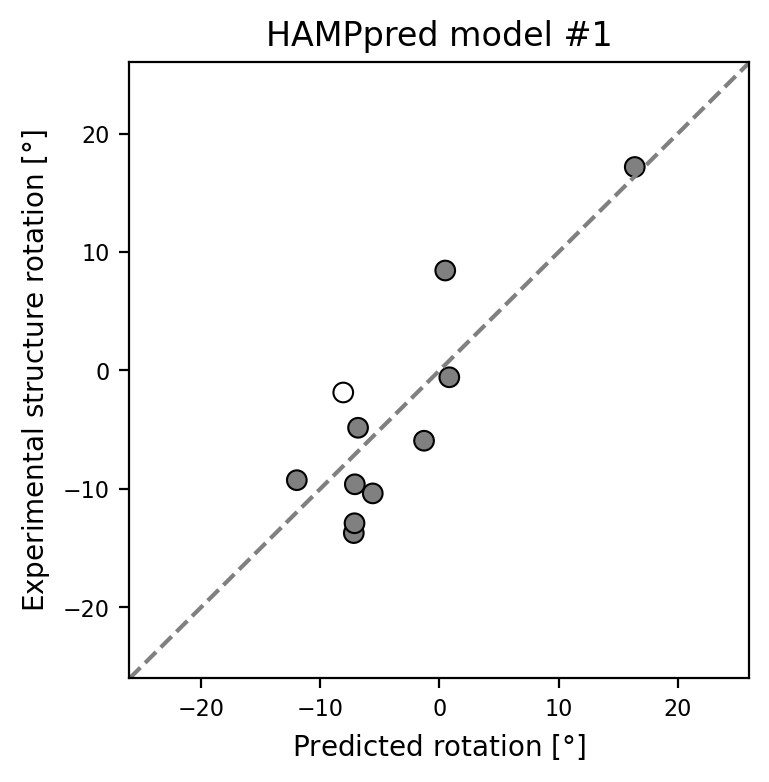

In [9]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred model #1", size=title_font_size)


In [10]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.69614525885471

# Performance on the validation set

In [13]:
data = f'{DATA_DIR}/af2_clean.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)

In [14]:
val = data.loc[val_ids]
seqs = list(val.train_seq)
tr=[]
for n,r in val.iterrows():
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seqs)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

/tmp/ipykernel_11287/79076738.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


2/2 [==============================] - 2s 194ms/step


Text(0.5, 1.0, 'Przewidywania dla zbioru walidacyjnego')

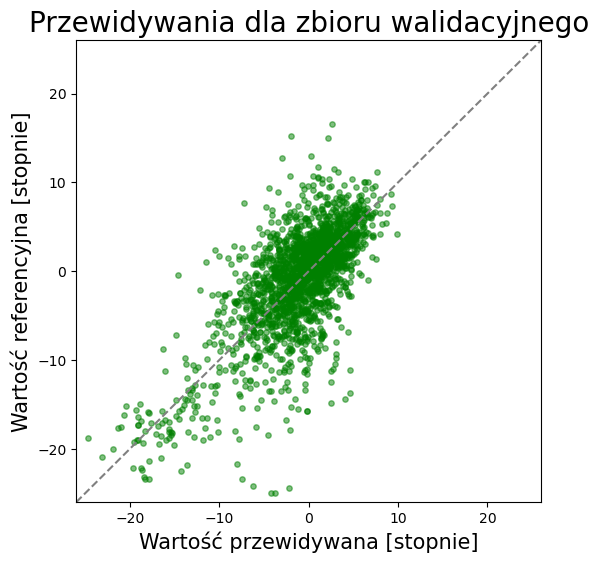

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=15, alpha=0.5)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
#ax.set_xlabel('Predicted', size=15)
#ax.set_ylabel('True', size=15)
#ax.set_title('Predictions for validation set')
ax.set_xlabel('Wartość przewidywana [stopnie]', size=15)
ax.set_ylabel('Wartość referencyjna [stopnie]', size=15)
ax.set_title('Przewidywania dla zbioru walidacyjnego', size=20)

In [16]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.29024825911657